In [13]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
import json

# Granger Causality Testing

### Covid Case Growth Rate approxmiation

In [8]:
from covid_activity.references import DATASET_DIR, cols
from covid_activity.experiments.causality import GrangerCausalityTest
from covid_activity.dataset.dataset_constructor import CountyDataLake, compute_diffs
from urllib.request import urlopen
import json
import plotly.express as px

dlake = CountyDataLake()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


In [9]:
with open(os.path.join(DATASET_DIR, 'full_policy_model.json'), 'r') as f:
    granger_casuality_county_results = json.loads(f.read())

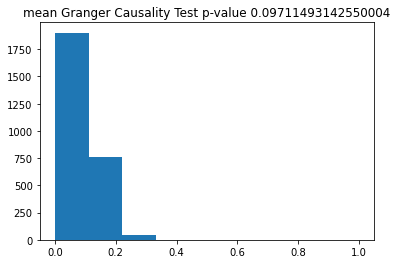

In [11]:
p_values = {}
for county, result in granger_casuality_county_results.items():
    p_value = result['p_value']
    if str(p_value) != 'nan':
        p_values[county] = p_value
raw_values = [v for k,v in p_values.items()]
plt.title(f"mean Granger Causality Test p-value {np.mean(raw_values)}")
plt.hist(raw_values, bins=np.linspace(0,1, 10));

#### Visualize distribution of P-values for each subnational unit

In [12]:
p_values = {}
for county, result in granger_casuality_county_results.items():
    p_value = result['p_value']
    if str(p_value) != 'nan':
        p_values[county] = p_value
raw_values = [v for k,v in p_values.items()]
p_values = pd.DataFrame.from_dict(p_values, orient='index').reset_index()
p_values

NameError: name 'pd' is not defined

In [ ]:
county_fips = dlake.activities._get_county_fips()

In [ ]:
p_value_fips_to_county_map = pd.merge(
    how='left',
    left=p_values,
    right=county_fips,
    left_on='index',
    right_on='county'
)
df = p_value_fips_to_county_map[['fips',0]]
df.columns = ['fips', 'p_value']
df = df.sort_values('fips')
df = df[df['fips'].apply(str) != 'nan']

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

fig = px.choropleth(df, 
                    geojson=counties, 
                    locations='fips', 
                    color='p_value',
                    color_continuous_scale="Viridis",
                    range_color=(0, .25),
                    scope="usa",
                    labels={'p_value':'Granger Casuality Significance'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Country Level Model by combining subnational units

In [14]:
full_model = np.zeros_like(result['full_model'])
reduced_model = np.zeros_like(result['reduced_model'])
weights = []
for county, result in granger_casuality_county_results.items():
    population_density = result['population_density']
    full_model += np.asarray(result['full_model']) * population_density
    reduced_model += np.asarray(result['reduced_model'])  * population_density
    weights.append(population_density)

full_model /= np.sum(weights)
reduced_model /= np.sum(weights)
full_model = full_model.reshape(-1, 1)
reduced_model = reduced_model.reshape(-1,1)

In [27]:
cccpaap_masked = dlake.get_county_case_counts_pop_activity_landarea_policy()
cccpaap_masked = compute_diffs(cccpaap_masked, Y_value='cases')
X = cccpaap_masked[cols],
Y = cccpaap_masked[['daily_growth_rate']]


Starting Test


### County Death Rate Approximation

## Feature Importance
> For this experiment to try and mitgate some of the noise and spareness in changes of the growth rate I changed this problem to a classification proble where a model attempts to use information from the policy to decide whether or not the growth rate is going up, down, or not changing

In [154]:
from covid_activity.experiments.causality import GrangerCausalityTest
from covid_activity.dataset.dataset_constructor import CountyDataLake, compute_diffs
from covid_activity.references import DATASET_DIR, cols
import json
import os
import pandas as pd
import numpy as np
import pickle
np.random.seed(555)

In [155]:
dlake = CountyDataLake()
mlp_regressor = pickle.load(open(os.path.join(DATASET_DIR,'feature_importance_model.pickle'), 'rb'))
mlp_regressor

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


MLPClassifier(hidden_layer_sizes=(100, 100, 100))

In [156]:
cccpaap_masked = dlake.get_county_case_counts_pop_activity_landarea_policy()
cccpaap_masked = compute_diffs(cccpaap_masked)
X = cccpaap_masked[cols]
Y = cccpaap_masked[['daily_growth_rate']]

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [157]:
from covid_activity.experiments.causality import FeatureImportance
from sklearn.preprocessing import StandardScaler as Scalar
scalar = Scalar()
fi = FeatureImportance(
        model = mlp_regressor,
        X = X, 
        Y = Y,
        scalar = scalar 
    )
    

In [159]:
fi.X_train.shape

(656324, 92)

In [160]:
np.count_nonzero(np.sign(fi.Y_train).reshape(-1) == mlp_regressor.predict(fi.X_train)) / len(fi.Y_train)

0.8224383079088986

In [182]:
with open(os.path.join(DATASET_DIR, 'feature_importance_train.json'), 'r') as f:
    feature_importance_train_results = json.loads(f.read())
with open(os.path.join(DATASET_DIR, 'feature_importance_test.json'), 'r') as f:
    feature_importance_test_results = json.loads(f.read())


In [192]:
import json

In [212]:
os.path.join(DATASET_DIR, DATASET_DIR, DATASET_DIR)

'/Users/ilian/Desktop/research_projects/c3ai-covidchallenge/covid_activity/data'

In [206]:
s = pickle.dumps(mlp_regressor)
test = {
    's'.encode('utf-8'): s
}
with open(os.path.join('/Users/ilian/Downloads/', 'feature_importance_train.json'), 'wb') as f:
    json.dump(test, f, indent=4)

TypeError: a bytes-like object is required, not 'str'

In [183]:
FI_scores = []
FI_accuracies = []
accuracy = feature_importance_test_results.pop('accuracy')
for key, value in feature_importance_test_results.items():
    FI_scores.append(value[f'FI_{key}'])
    FI_accuracies.append(value[f'accuracy_perm'])
    

In [188]:
print(np.argmax(FI_scores))
print(FI_scores[np.argmax(FI_scores)])
print(FI_accuracies[np.argmax(FI_scores)])

88
1.4860876730690475
0.7380505085133128


## SIER model

In [65]:
from scipy.integrate import RK45
import re
from covid_activity.experiments.causality import GrangerCausalityTest
from covid_activity.dataset.dataset_constructor import CountyDataLake, compute_diffs
from covid_activity.references import DATASET_DIR, cols
dlake = CountyDataLake()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [70]:
cccpaap_masked = dlake.get_county_case_counts_pop_activity_landarea_policy()
cccpaap_masked = compute_diffs(cccpaap_masked, 'infection_')
cccpaap_masked = compute_diffs(cccpaap_masked, 'deaths_', 'deaths')
cccpaap_masked = cccpaap_masked.iloc[:, 2:]

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [149]:
X = cccpaap_masked[['day', 
                'county', 
                'population_density', 
                'cases', 
                'Quarantine',
                'start_stop',
                'infection_daily_change',
                'infection_daily_growth_rate',
                'deaths_daily_change',
                'deaths_daily_growth_rate' ]]

KeyError: "['infection_daily_change', 'deaths_daily_growth_rate', 'deaths_daily_change', 'infection_daily_growth_rate'] not in index"

In [99]:
X['start_stop'][X['start_stop'] == '0'] = 'stop'
X

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,day,county,population_density,cases,Quarantine,start_stop,infection_daily_change,infection_daily_growth_rate,deaths_daily_change,deaths_daily_growth_rate
0,0,Abbeville_SouthCarolina_UnitedStates,47.988652,0.0,0.0,stop,0.0,-6.907755,0.0,-6.907755
1,1,Abbeville_SouthCarolina_UnitedStates,47.988652,0.0,0.0,stop,0.0,0.000000,0.0,0.000000
2,2,Abbeville_SouthCarolina_UnitedStates,47.988652,0.0,0.0,stop,0.0,0.000000,0.0,0.000000
3,3,Abbeville_SouthCarolina_UnitedStates,47.988652,0.0,0.0,stop,0.0,0.000000,0.0,0.000000
4,4,Abbeville_SouthCarolina_UnitedStates,47.988652,0.0,0.0,stop,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
875099,20,Sunflower_Mississippi_UnitedStates,35.503210,0.0,0.0,stop,0.0,0.000000,0.0,0.000000
875100,21,Sunflower_Mississippi_UnitedStates,35.503210,0.0,0.0,stop,0.0,0.000000,0.0,0.000000
875101,22,Sunflower_Mississippi_UnitedStates,35.503210,0.0,0.0,stop,0.0,0.000000,0.0,0.000000
875102,23,Sunflower_Mississippi_UnitedStates,35.503210,0.0,0.0,stop,0.0,0.000000,0.0,0.000000


In [91]:
X_no_policies = X[X['start_stop'] == 'stop']
X_policies = X[X['start_stop'] == 'start']

In [133]:
county_name = 'Braxton_WestVirginia_UnitedStates' 
county = X[X['county'] == county_name]

In [134]:
county[county['start_stop'] == 'stop']['infection_daily_growth_rate'].mean()

-0.0073986629963871155

In [135]:
county[county['start_stop'] == 'start']['infection_daily_growth_rate'].mean()

0.006069608755660117

In [117]:
list(X['county'].unique())

['Abbeville_SouthCarolina_UnitedStates',
 'Acadia_Louisiana_UnitedStates',
 'Accomack_Virginia_UnitedStates',
 'Ada_Idaho_UnitedStates',
 'Adair_Iowa_UnitedStates',
 'Adair_Kentucky_UnitedStates',
 'Adair_Missouri_UnitedStates',
 'Adair_Oklahoma_UnitedStates',
 'Adams_Colorado_UnitedStates',
 'Adams_Idaho_UnitedStates',
 'Adams_Illinois_UnitedStates',
 'Adams_Indiana_UnitedStates',
 'Adams_Iowa_UnitedStates',
 'Adams_Mississippi_UnitedStates',
 'Adams_Nebraska_UnitedStates',
 'Adams_NorthDakota_UnitedStates',
 'Adams_Ohio_UnitedStates',
 'Adams_Pennsylvania_UnitedStates',
 'Adams_Washington_UnitedStates',
 'Adams_Wisconsin_UnitedStates',
 'Addison_Vermont_UnitedStates',
 'Aiken_SouthCarolina_UnitedStates',
 'Aitkin_Minnesota_UnitedStates',
 'Alachua_Florida_UnitedStates',
 'Alamance_NorthCarolina_UnitedStates',
 'Alameda_California_UnitedStates',
 'Alamosa_Colorado_UnitedStates',
 'Albany_NewYork_UnitedStates',
 'Albany_Wyoming_UnitedStates',
 'Albemarle_Virginia_UnitedStates',
 'Alcon